In [1]:
import numpy as np
import math
import pandas as pd
import random

import thinkstats2
import thinkplot
import brfss
import nsfg
import first

In [2]:
class CoinTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat
    
    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

In [3]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.055

In [4]:
class DiffMeansPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
        
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [5]:
live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.153

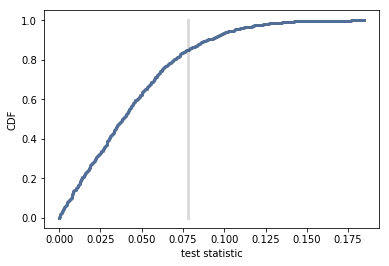

<Figure size 576x432 with 0 Axes>

In [6]:
ht.PlotCdf()
thinkplot.Show(xlabel='test statistic', ylabel='CDF')

In [7]:
class DiffMeansOneSided(DiffMeansPermute):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

hto = DiffMeansOneSided(data)
hto.PValue()

0.088

In [8]:
class DiffStdPermute(DiffMeansPermute):
    
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

hst = DiffStdPermute(data)
hst.PValue()

0.084

In [9]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat
    
    def RunModel(self):
        xs, ys = data
        xs = np.random.permutation(xs)
        return xs, ys

In [10]:
live_s = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data_s = live_s.agepreg.values, live_s.totalwgt_lb.values
ht = CorrelationPermute(data_s)
pvalue = ht.PValue()
pvalue

ValueError: shapes (4413,) and (4735,) not aligned: 4413 (dim 0) != 4735 (dim 0)

In [11]:
class DiceTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat
    
    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

In [12]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
dt.PValue(iters=1000)

0.132

In [13]:
class DiceChiTest(DiceTest):
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected) ** 2 / expected)
        return test_stat

In [14]:
dct = DiceChiTest(data)
dct.PValue(iters=1000)

0.046

In [15]:
class PregLengthTest(thinkstats2.HypothesisTest):
    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))
        
        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))
    
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat
    
    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected) ** 2 / expected)
        return stat

In [16]:
data = firsts.prglngth.values, others.prglngth.values
plt = PregLengthTest(data)
pvalue = plt.PValue()
print('pvalue', pvalue)
print('actual', plt.actual)
print('max value', plt.MaxTestStat())

pvalue 0.0
actual 101.50141482893264
max value 34.66383229481113


In [17]:
def FalseNegRate(data, num_runs=100):
    group1, group2 = data
    count = 0
    
    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        
        ht = DiffMeansPermute((sample1, sample2))
        pvalue = ht.PValue(iters=101)
        if pvalue > 0.05:
            count += 1
    
    return count / num_runs , pvalue

In [18]:
data = firsts.prglngth.values, others.prglngth.values
neg_rate = FalseNegRate(data)
neg_rate

(0.64, 0.009900990099009901)

# Exercises

## 9.1

In [19]:
live, firsts, others = first.MakeFrames()
first_b = firsts.prglngth
other_b = others.prglngth

In [20]:
data = thinkstats2.SampleRows(first_b, 10000, replace=True), thinkstats2.SampleRows(other_b, 10000, replace=True)

In [21]:
FalseNegRate(data, 1000)

(0.032, 0.0)

In [22]:
def FindSampleSize(group1, group2, nruns=100, req=0.8):
    samp_size = 20000
    fnrs = []
    ps = []
    while True:
        samp_size += 100
        g1 = thinkstats2.SampleRows(group1, samp_size, replace=True)
        g2 = thinkstats2.SampleRows(group2, samp_size, replace=True)
        fnr, pvalue = FalseNegRate((g1, g2), nruns)
        fnrs.append(fnr)
        ps.append(pvalue)
        
        if (samp_size % 1000) == 0:
            print('samp_size:', samp_size, ', FNR:', np.mean(fnrs), ', pvalue', pvalue)
            if np.mean(fnrs) < 0.2:
                break
            fnrs = []
            ps = []
        
    print('Required sample size for positive test:', samp_size)

In [23]:
FindSampleSize(first_b, other_b)

samp_size: 21000 , FNR: 0.24200000000000005 , pvalue 0.009900990099009901
samp_size: 22000 , FNR: 0.083 , pvalue 0.04950495049504951
Required sample size for positive test: 22000


In [28]:
live, firsts, others = first.MakeFrames()
data_len = firsts.prglngth.values, others.prglngth.values
data_wgt = firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values

In [29]:
class DiffMeansResample(DiffMeansPermute):
    def RunModel(self):
        g1 = np.random.choice(self.pool, self.n, replace=True)
        g2 = np.random.choice(self.pool, self.m, replace=True)
        return g1, g2

In [30]:
dms_l = DiffMeansResample(data_len)
dms_w = DiffMeansResample(data_wgt)
pvalue = dms_l.PValue(iters=1000), dms_w.PValue(iters=1000)
pvalue

(0.149, 0.0)

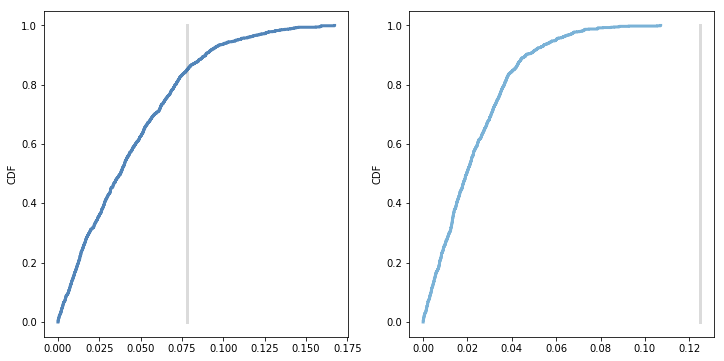

<Figure size 576x432 with 0 Axes>

In [31]:
thinkplot.PrePlot(2, cols=2)
dms_l.PlotCdf()
thinkplot.Config(label='Preg Length', ylabel='CDF')
thinkplot.SubPlot(2)
dms_w.PlotCdf()
thinkplot.Config(label='Birth Weight', ylabel='CDF')
thinkplot.Show()